Importing required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input as resnet50v2_preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input, ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import seaborn as sns
from itertools import cycle
from math import ceil

#### 1. Data exploration and preprocessing

In [2]:
""" Dataset directories """
train_data_dir = "Dataset/Preprocessed/Tomato/train_set"
test_data_dir = "Dataset/Preprocessed/Tomato/test_set"

In [3]:
""" Get the first image from the healthy directory """
first_image_file = os.listdir(f"{train_data_dir}/healthy")[0]
img = plt.imread(f"{train_data_dir}/healthy/{first_image_file}")

img_height, img_width, _ = img.shape

img_size = min(img_height, img_width)

print(f"Image size: {img_height}x{img_width} -> {img_size}")

Image size: 400x400 -> 400


In [4]:
""" Set batch size """
batch_size = 32

In [5]:
""" Data augmentation and preprocessing """
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)

Found 21723 images belonging to 5 classes.
Found 5445 images belonging to 5 classes.


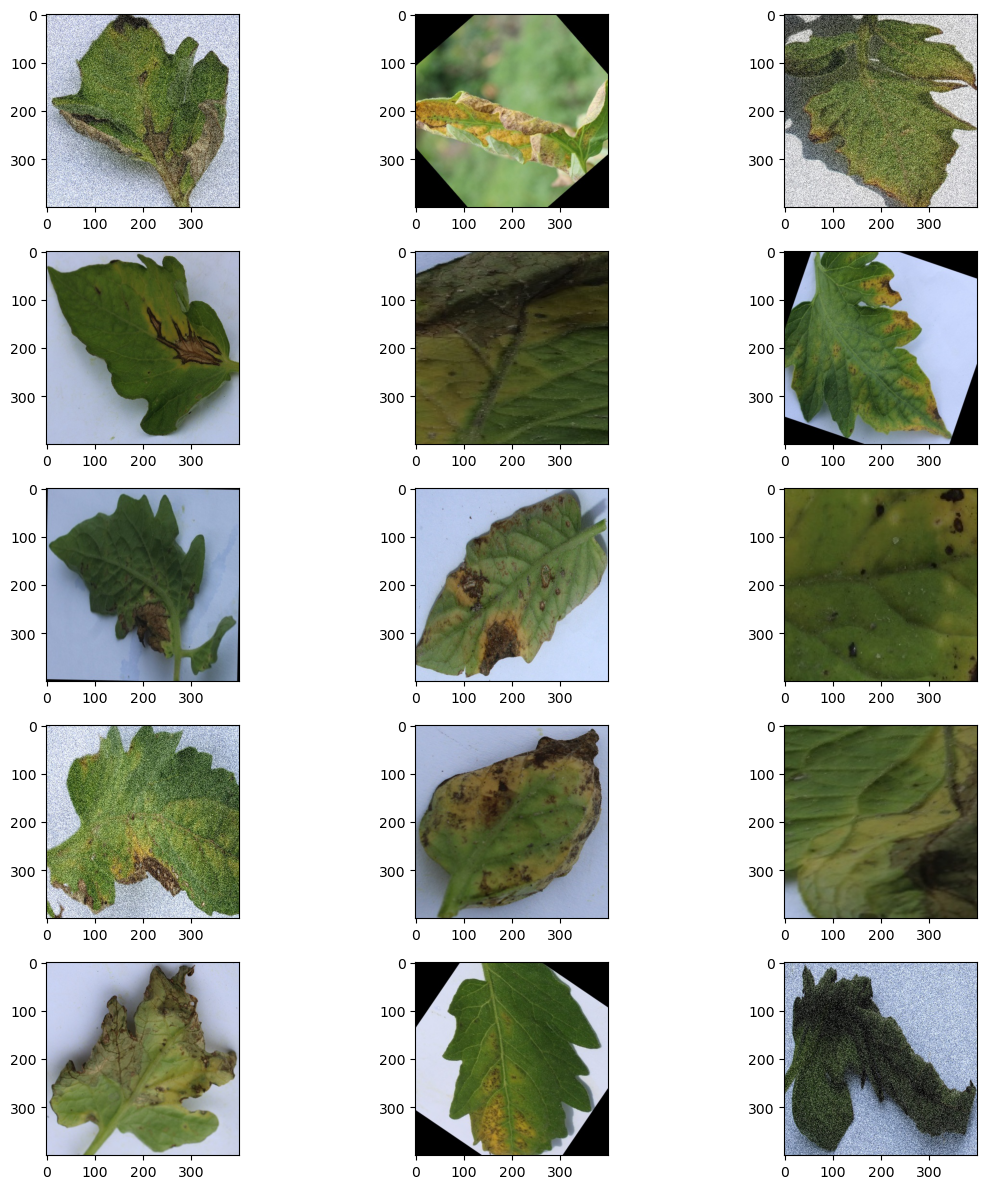

In [6]:
""" Display sample images """
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [7]:
""" Number of classes """
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 5


#### 2. Model training

In [8]:
def SamplesPerClass(dir_path):
    num_samples = []
    class_labels = os.listdir(dir_path)
    for class_label in class_labels:
        class_dir = os.path.join(train_data_dir, class_label)
        if os.path.isdir(class_dir):
            num_samples.append(len(os.listdir(class_dir)))
    return np.array(num_samples)

num_samples = SamplesPerClass(train_data_dir)
total_samples = np.sum(num_samples)
class_frequencies = num_samples / total_samples
inverse_class_frequencies = 1 / class_frequencies
class_weights = inverse_class_frequencies / np.sum(inverse_class_frequencies)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class_weights_dict

{0: 0.3106781363030128,
 1: 0.11949159088577416,
 2: 0.3031006207834271,
 3: 0.06629214473551963,
 4: 0.2004375072922663}

In [9]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.8, min_lr=0.00001)

Training ResNet-50 model

In [10]:
""" Load ResNet50V2 model """
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

""" Freeze the base model """
for layer in base_resNet_model.layers:
    layer.trainable = False
    
""" Add custom layers """
x = base_resNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

""" Create model """
resnet_model = Model(inputs=base_resNet_model.input, outputs=predictions)

""" Compile model """
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
""" Train model """
resNet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    class_weight=class_weights_dict,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
678/678 [==============================] - 2519s 4s/step - loss: 0.1519 - accuracy: 0.5198 - val_loss: 0.9374 - val_accuracy: 0.6042
Epoch 2/200
678/678 [==============================] - 2354s 3s/step - loss: 0.1162 - accuracy: 0.6110 - val_loss: 0.7541 - val_accuracy: 0.6925
Epoch 3/200
678/678 [==============================] - 2328s 3s/step - loss: 0.1013 - accuracy: 0.6589 - val_loss: 0.7043 - val_accuracy: 0.7160
Epoch 4/200
678/678 [==============================] - 2316s 3s/step - loss: 0.0919 - accuracy: 0.6892 - val_loss: 0.7280 - val_accuracy: 0.7123
Epoch 5/200
678/678 [==============================] - 2324s 3s/step - loss: 0.0814 - accuracy: 0.7195 - val_loss: 0.5603 - val_accuracy: 0.7877
Epoch 6/200
678/678 [==============================] - 2322s 3s/step - loss: 0.0742 - accuracy: 0.7472 - val_loss: 0.4748 - val_accuracy: 0.8176
Epoch 7/200
678/678 [==============================] - 2322s 3s/step - loss: 0.0669 - accuracy: 0.7684 - val_loss: 0.4402 - val_ac

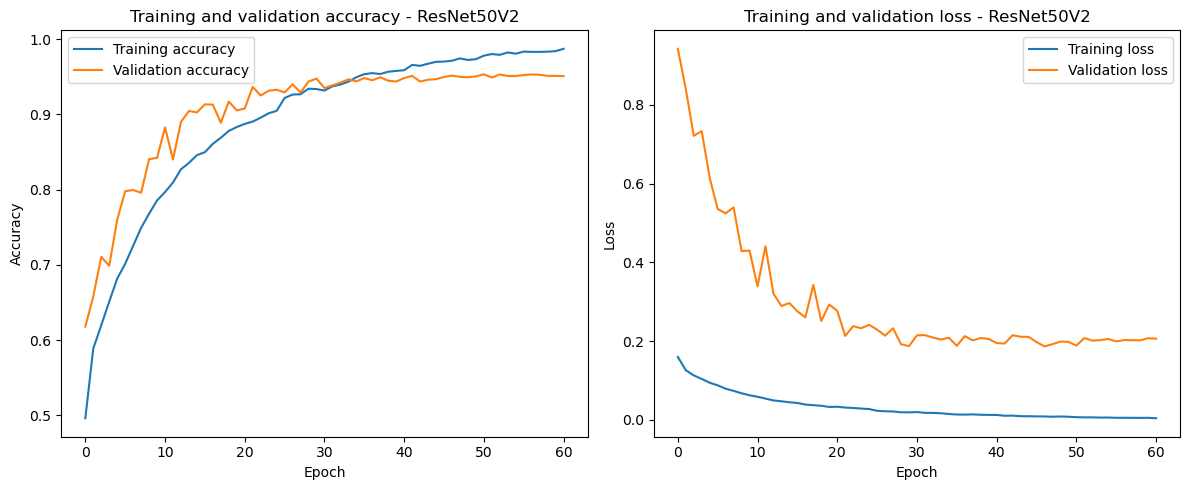

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

""" Plot training and validation accuracy """
axs[0].plot(resNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - ResNet50V2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

""" Plot training and validation loss """
axs[1].plot(resNet_history.history["loss"], label="Training loss")
axs[1].plot(resNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - ResNet50V2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [26]:
""" Save model """
resnet_model.save("Models/resNet_model.h5")

""" Save history """
with open("Models/resNet_history.pkl", "wb") as f:
    pkl.dump(resNet_history.history, f)

c:\ProgramData\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


#### 3. Model Evaluation

In [27]:
""" Evaluate model """
score = resnet_model.evaluate(test_generator)

print(f"Test loss: {score[0]:.3f}")
print(f"Test accuracy: {score[1]:.3f}")

341/341 [==============================] - 20s 57ms/step - loss: 0.1889 - accuracy: 0.9530
Test loss: 0.189
Test accuracy: 0.953


In [11]:
# Loading the model and history for model evaluation
model = tf.keras.models.load_model("Model/resNet_model_v0.h5")

history_path = 'Model/resNet_history_v0.pkl'
with open(history_path, 'rb') as file:
    history = pkl.load(file)

In [14]:
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

In [15]:
# Changing shuffle to false for evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # Important for alignment
    seed=42
)

Found 5445 images belonging to 5 classes.


In [18]:
# Calculate the correct number of steps per epoch
steps = ceil(test_generator.samples / test_generator.batch_size)

# Generate predictions
predictions = model.predict(test_generator, steps=steps)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes[:len(y_pred)]

In [25]:
# Printing the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score: {f1}")

F1 Score: 0.9527600222827347


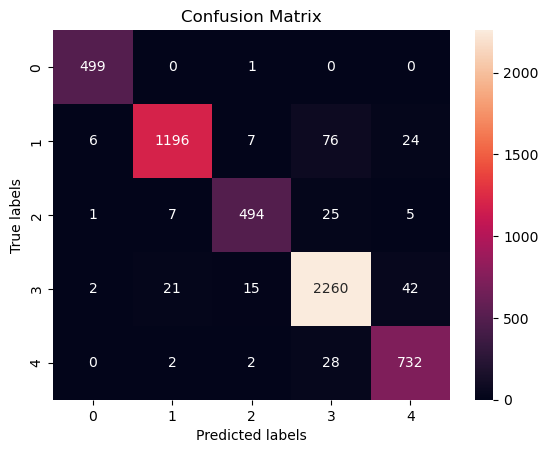

In [24]:
# Plotting the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Binarize the output for plotting the ROC curve
y_test_binarized = label_binarize(y_true, classes=np.arange(test_generator.num_classes))

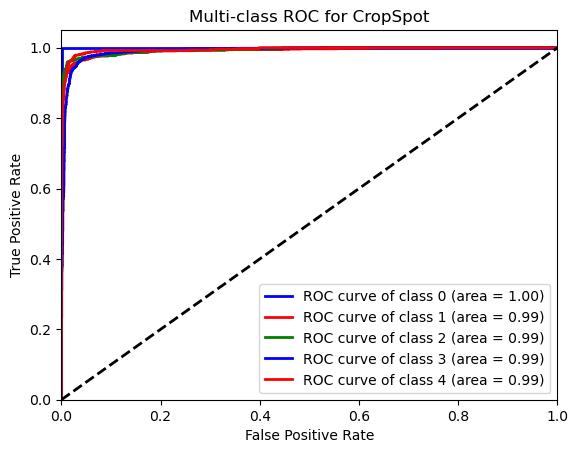

In [26]:
# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for CropSpot')
plt.legend(loc="lower right")
plt.show()

#### 4. Model Testing

In [15]:
# Path to validaiton dataset
new_dataset_dir = 'Dataset/Preprocessed/tomato_val'

In [16]:
# Set up the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Assuming a structure of new_dataset_dir/class_x for each class
class_names = ["healthy", "leaf blight", "leaf curl", "septoria leaf spot"]

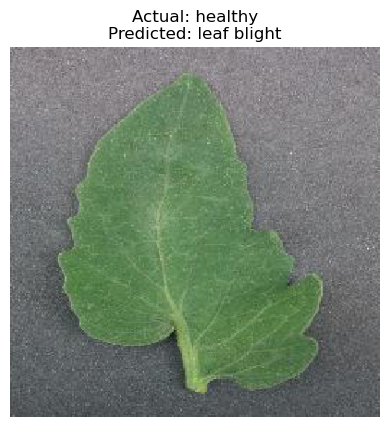

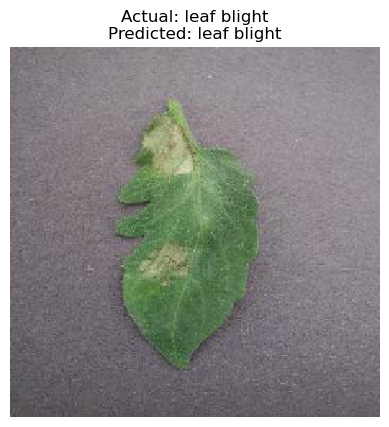

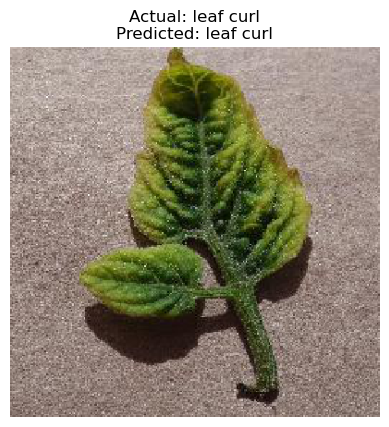

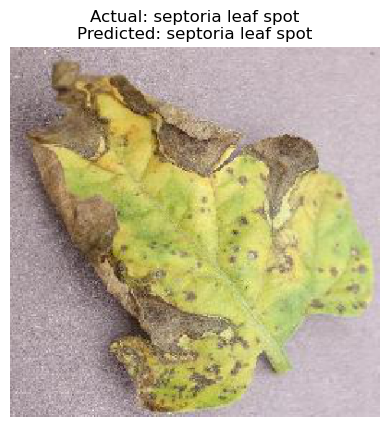

In [26]:
for class_name in class_names:
    class_dir = os.path.join(new_dataset_dir, class_name)
    images = os.listdir(class_dir)
    random_image_name = random.choice(images)
    image_path = os.path.join(class_dir, random_image_name)
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))  # Ensure img_size matches your model's expected input
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0
    
    # Predict
    prediction = model.predict(img_array_expanded)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    
    # Handle prediction safely
    if predicted_class_index < len(class_names):
        predicted_class_name = class_names[predicted_class_index]
    else:
        predicted_class_name = "Unknown Class"  # For when the model predicts the class not present in the new dataset
    # Display
    plt.imshow(img)
    plt.title(f"Actual: {class_name}\nPredicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

In [37]:
true_labels = []
predicted_labels = []

for class_name in class_names:
    class_dir = os.path.join(new_dataset_dir, class_name)
    images = os.listdir(class_dir)
    random_image_name = random.choice(images)  # For one image per class
    image_path = os.path.join(class_dir, random_image_name)
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0
    
    # Predict
    prediction = model.predict(img_array_expanded)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    
    # Append true and predicted labels for confusion matrix
    true_labels.append(class_names.index(class_name))
    predicted_labels.append(predicted_class_index)

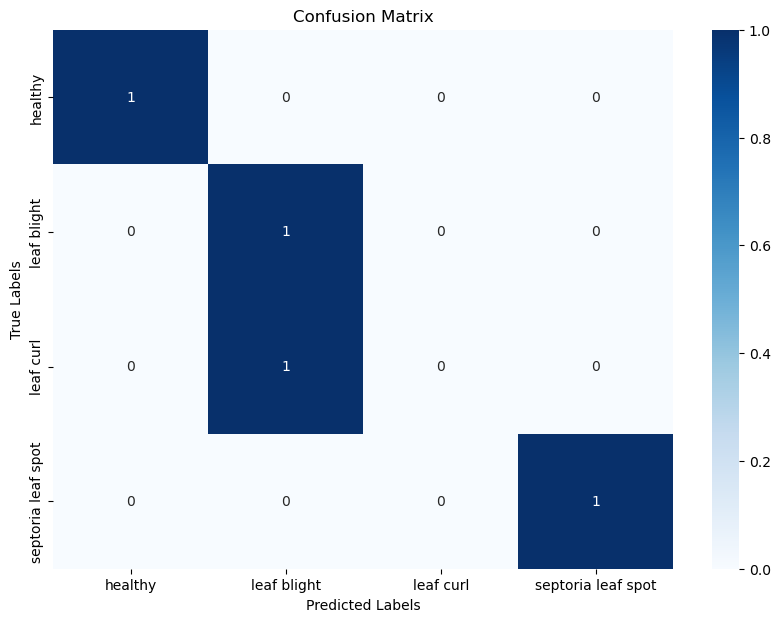

In [38]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()